<a href="https://colab.research.google.com/github/Dianjoo/UjiCoba1/blob/main/Klasifikasi_Berita_dengan_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://2.bp.blogspot.com/-066qpJs0Ttc/WiYPXGNYEYI/AAAAAAAAFu8/XbOaf7DqfDMM9truu3DkrkIGfRgP4zBzgCLcBGAs/s1600/udinus.jpg"  width="200">

# **Klasifikasi Berita dengan Naive Bayes**




# load drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Coba Code/main/Code Jadi')

Mounted at /content/drive


# install library ekphrasis

In [ ]:
!pip install ekphrasis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 8.8 MB/s eta 0:00:00


In [ ]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


# load library

In [ ]:
import re
import string
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


# load dataset

In [ ]:
df = pd.read_excel('/content/drive/My Drive/Coba Code/main/Code Jadi/news.xlsx')

In [ ]:
df.head()

,Nomor,Article Title,Article Link,Article Content,Kategori
0,1,"7 Hobi yang Bisa Datangkan Cuan di 2022, Ada H...",https://www.detik.com/edu/edutainment/d-588006...,Meski banyak orang menganggap hobi hanya sebat...,EDU
1,2,"Perbanyak Ahli Gunung Api, ITN Yogyakarta Buka...",https://www.detik.com/edu/perguruan-tinggi/d-5...,Institut Teknologi Nasional (ITN) Yogyakarta m...,EDU
2,3,"PTM Terbatas 2022 di Jakarta, Ini Aturan Kegia...",https://www.detik.com/edu/sekolah/d-5880075/pt...,Pemerintah Provinsi DKI Jakarta melalui Kepala...,EDU
3,4,Mengapa Perlu Menjaga Kelestarian Tanaman Baka...,https://www.detik.com/edu/detikpedia/d-5879161...,Tanaman bakau adalah salah satu ekosistem yang...,EDU
4,5,Cara Membuat Surat Lamaran Kerja yang Sempurna...,https://www.detik.com/edu/edutainment/d-587992...,Membuat Curriculum Vitae (CV) dan surat lamara...,EDU


Karena hanya ingin fokus di Klasifikasi berita, maka hanya memakai `Article Content` sebagai target class nya **class**

In [ ]:
df = df.drop(['Nomor','Article Title','Article Link'], axis=1)

In [ ]:
text_df = df[['Kategori','Article Content']]
text_df.head()

,Kategori,Article Content
0,EDU,Meski banyak orang menganggap hobi hanya sebat...
1,EDU,Institut Teknologi Nasional (ITN) Yogyakarta m...
2,EDU,Pemerintah Provinsi DKI Jakarta melalui Kepala...
3,EDU,Tanaman bakau adalah salah satu ekosistem yang...
4,EDU,Membuat Curriculum Vitae (CV) dan surat lamara...


In [ ]:
text_df['length'] = text_df['Article Content'].apply(len)
text_df.head()

<ipython-input-9-65020e1dbf9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df['length'] = text_df['Article Content'].apply(len)


,Kategori,Article Content,length
0,EDU,Meski banyak orang menganggap hobi hanya sebat...,3834
1,EDU,Institut Teknologi Nasional (ITN) Yogyakarta m...,2511
2,EDU,Pemerintah Provinsi DKI Jakarta melalui Kepala...,2698
3,EDU,Tanaman bakau adalah salah satu ekosistem yang...,2535
4,EDU,Membuat Curriculum Vitae (CV) dan surat lamara...,2247


In [ ]:
text_df.Kategori.unique()

array(['EDU', 'HOT', 'FNC', 'NEWS', 'BOLA', 'OTO'], dtype=object)

In [ ]:
text_df.Kategori.value_counts()

HOT     501
NEWS    500
EDU     498
FNC     480
OTO     304
BOLA    210
Name: Kategori, dtype: int64

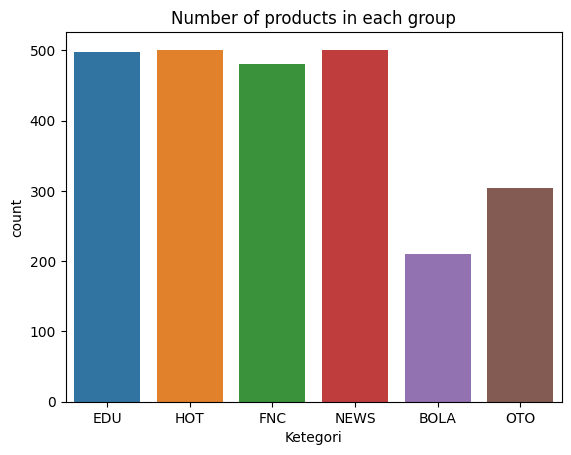

In [ ]:
#Visualisasi data dalam bentuk diagram
sns.countplot(x='Kategori',data=text_df)
plt.xlabel('Ketegori')
plt.title('Number of products in each group');

# Preprocessing

## setting fungsi

In [ ]:
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text)

## running preprocessing
logika main disini

In [ ]:
final_string = []
for text in df['Article Content'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc)
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

masukkan hasil preprocessing ke kolom `step01`

In [ ]:
df["step01"] = final_string

In [ ]:
df.head()

,Article Content,Kategori,step01
0,Meski banyak orang menganggap hobi hanya sebat...,EDU,meski banyak orang menganggap hobi hanya sebat...
1,Institut Teknologi Nasional (ITN) Yogyakarta m...,EDU,institut teknologi nasional allcaps itn allcap...
2,Pemerintah Provinsi DKI Jakarta melalui Kepala...,EDU,pemerintah provinsi allcaps dki allcaps jakart...
3,Tanaman bakau adalah salah satu ekosistem yang...,EDU,tanaman bakau adalah salah satu ekosistem yang...
4,Membuat Curriculum Vitae (CV) dan surat lamara...,EDU,membuat curriculum vitae cv dan surat lamaran ...


cek jumlah dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2493 entries, 0 to 2492
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Article Content  2493 non-null   object
 1   Kategori         2493 non-null   object
 2   step01           2493 non-null   object
dtypes: object(3)
memory usage: 58.6+ KB


## hapus record yang kosong

In [ ]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [ ]:
df_new = df[~df.isin(df_hapus)].dropna()

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2493 entries, 0 to 2492
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Article Content  2493 non-null   object
 1   Kategori         2493 non-null   object
 2   step01           2493 non-null   object
dtypes: object(3)
memory usage: 58.6+ KB


## normalisasi kata slang

In [ ]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [ ]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [ ]:
df_new.head(10)

,Article Content,Kategori,step01,tokens
0,Meski banyak orang menganggap hobi hanya sebat...,EDU,meski banyak orang menganggap hobi hanya sebat...,"[meski, banyak, orang, menganggap, hobi, hanya..."
1,Institut Teknologi Nasional (ITN) Yogyakarta m...,EDU,institut teknologi nasional allcaps itn allcap...,"[institut, teknologi, nasional, allcaps, itn, ..."
2,Pemerintah Provinsi DKI Jakarta melalui Kepala...,EDU,pemerintah provinsi allcaps dki allcaps jakart...,"[pemerintah, provinsi, allcaps, dki, allcaps, ..."
3,Tanaman bakau adalah salah satu ekosistem yang...,EDU,tanaman bakau adalah salah satu ekosistem yang...,"[tanaman, bakau, adalah, salah, satu, ekosiste..."
4,Membuat Curriculum Vitae (CV) dan surat lamara...,EDU,membuat curriculum vitae cv dan surat lamaran ...,"[membuat, curriculum, vitae, cv, dan, surat, l..."
5,Indonesia memiliki jam sekolah yang cukup panj...,EDU,indonesia memiliki jam sekolah yang cukup panj...,"[indonesia, memiliki, jam, sekolah, yang, cuku..."
6,Keputusan itu merupakan lanjutan dari Surat Ke...,EDU,keputusan itu merupakan lanjutan dari surat ke...,"[keputusan, itu, merupakan, lanjutan, dari, su..."
7,Pelestarian sumber daya alam adalah upaya peng...,EDU,pelestarian sumber daya alam adalah upaya peng...,"[pelestarian, sumber, daya, alam, adalah, upay..."
8,Universitas Brawijaya (UB) telah berubah menja...,EDU,universitas brawijaya ub telah berubah menjadi...,"[universitas, brawijaya, ub, telah, berubah, m..."
9,Penelitian tentang mimpi hewan sudah dilakukan...,EDU,penelitian tentang mimpi hewan sudah dilakukan...,"[penelitian, tentang, mimpi, hewan, sudah, dil..."


In [ ]:
normalized_word = pd.read_excel('/content/drive/My Drive/Coba Code/main/Code Jadi/kamus perbaikan kata.xlsx')

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

In [ ]:
df_new.head()

,Article Content,Kategori,step01,tokens,tokens_perbaikan
0,Meski banyak orang menganggap hobi hanya sebat...,EDU,meski banyak orang menganggap hobi hanya sebat...,"[meski, banyak, orang, menganggap, hobi, hanya...","[meski, banyak, orang, menganggap, hobi, hanya..."
1,Institut Teknologi Nasional (ITN) Yogyakarta m...,EDU,institut teknologi nasional allcaps itn allcap...,"[institut, teknologi, nasional, allcaps, itn, ...","[institut, teknologi, nasional, allcaps, itn, ..."
2,Pemerintah Provinsi DKI Jakarta melalui Kepala...,EDU,pemerintah provinsi allcaps dki allcaps jakart...,"[pemerintah, provinsi, allcaps, dki, allcaps, ...","[pemerintah, provinsi, allcaps, dki, allcaps, ..."
3,Tanaman bakau adalah salah satu ekosistem yang...,EDU,tanaman bakau adalah salah satu ekosistem yang...,"[tanaman, bakau, adalah, salah, satu, ekosiste...","[tanaman, bakau, adalah, salah, satu, ekosiste..."
4,Membuat Curriculum Vitae (CV) dan surat lamara...,EDU,membuat curriculum vitae cv dan surat lamaran ...,"[membuat, curriculum, vitae, cv, dan, surat, l...","[membuat, curriculum, vitae, cv, dan, surat, l..."


In [ ]:
df_new.iloc[0].tokens

['meski',
 'banyak',
 'orang',
 'menganggap',
 'hobi',
 'hanya',
 'sebatas',
 'hiburan',
 'menghilangkan',
 'penat',
 'namun',
 'sebagian',
 'lagi',
 'menganggap',
 'ada',
 'hobi',
 'yang',
 'bisa',
 'dijadikan',
 'peluang',
 'menghasilkan',
 'cuan',
 'terlebih',
 'di',
 'awal',
 'tahun',
 'baru',
 'number',
 'pasti',
 'banyak',
 'yang',
 'memiliki',
 'resolusi',
 'untuk',
 'menambah',
 'lebih',
 'banyak',
 'cuan',
 'lantas',
 'apa',
 'saja',
 'hobi',
 'tersebut',
 'berikut',
 'rangkumannya',
 'tidak',
 'bisa',
 'dipungkiri',
 'bahwa',
 'hobi',
 'menulis',
 'masih',
 'akan',
 'berpeluang',
 'besar',
 'mendatangkan',
 'cuan',
 'di',
 'number',
 'bagi',
 'mahasiswa',
 'yang',
 'tertarik',
 'bekerja',
 'dengan',
 'waktu',
 'fleksibel',
 'pekerjaan',
 'sebagai',
 'content',
 'writer',
 'bisa',
 'dicoba',
 'kamu',
 'bisa',
 'mulai',
 'menulis',
 'dan',
 'mengirimkannya',
 'ke',
 'beberapa',
 'media',
 'online',
 'atau',
 'cetak',
 'yang',
 'bisa',
 'menerima',
 'tulisan',
 'berbayar',
 'kam

## Stopword - Menggunakan Modul NLTK

In [ ]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Article Content,Kategori,step01,tokens,tokens_perbaikan,Stop_removal
0,Meski banyak orang menganggap hobi hanya sebat...,EDU,meski banyak orang menganggap hobi hanya sebat...,"[meski, banyak, orang, menganggap, hobi, hanya...","[meski, banyak, orang, menganggap, hobi, hanya...","[orang, menganggap, hobi, sebatas, hiburan, me..."
1,Institut Teknologi Nasional (ITN) Yogyakarta m...,EDU,institut teknologi nasional allcaps itn allcap...,"[institut, teknologi, nasional, allcaps, itn, ...","[institut, teknologi, nasional, allcaps, itn, ...","[institut, teknologi, nasional, allcaps, itn, ..."
2,Pemerintah Provinsi DKI Jakarta melalui Kepala...,EDU,pemerintah provinsi allcaps dki allcaps jakart...,"[pemerintah, provinsi, allcaps, dki, allcaps, ...","[pemerintah, provinsi, allcaps, dki, allcaps, ...","[pemerintah, provinsi, allcaps, dki, allcaps, ..."
3,Tanaman bakau adalah salah satu ekosistem yang...,EDU,tanaman bakau adalah salah satu ekosistem yang...,"[tanaman, bakau, adalah, salah, satu, ekosiste...","[tanaman, bakau, adalah, salah, satu, ekosiste...","[tanaman, bakau, salah, ekosistem, tumbuh, mua..."
4,Membuat Curriculum Vitae (CV) dan surat lamara...,EDU,membuat curriculum vitae cv dan surat lamaran ...,"[membuat, curriculum, vitae, cv, dan, surat, l...","[membuat, curriculum, vitae, cv, dan, surat, l...","[curriculum, vitae, cv, surat, lamaran, kerja,..."
...,...,...,...,...,...,...
2488,Satu unit Jeep Wrangler Rubicon tengah dilelan...,OTO,satu unit jeep wrangler rubicon tengah dilelan...,"[satu, unit, jeep, wrangler, rubicon, tengah, ...","[satu, unit, jeep, wrangler, rubicon, tengah, ...","[unit, jeep, wrangler, rubicon, dilelang, nega..."
2489,"Jakarta - Mengawali 2022, Mitsubishi secara re...",OTO,jakarta mengawali number mitsubishi secara res...,"[jakarta, mengawali, number, mitsubishi, secar...","[jakarta, mengawali, number, mitsubishi, secar...","[jakarta, mengawali, number, mitsubishi, resmi..."
2490,Pekan ini Direktorat Lalu Lintas Polda Metro J...,OTO,pekan ini direktorat lalu lintas polda metro j...,"[pekan, ini, direktorat, lalu, lintas, polda, ...","[pekan, ini, direktorat, lalu, lintas, polda, ...","[pekan, direktorat, lintas, polda, metro, jaya..."
2491,Belum lama ini viral pernyataan pengamat yang ...,OTO,belum lama ini viral pernyataan pengamat yang ...,"[belum, lama, ini, viral, pernyataan, pengamat...","[belum, lama, ini, viral, pernyataan, pengamat...","[viral, pernyataan, pengamat, mobil, roof, box..."


In [ ]:
df_new.iloc[0].tokens_perbaikan

['meski',
 'banyak',
 'orang',
 'menganggap',
 'hobi',
 'hanya',
 'sebatas',
 'hiburan',
 'menghilangkan',
 'penat',
 'namun',
 'sebagian',
 'lagi',
 'menganggap',
 'ada',
 'hobi',
 'yang',
 'bisa',
 'dijadikan',
 'peluang',
 'menghasilkan',
 'cuan',
 'terlebih',
 'di',
 'awal',
 'tahun',
 'baru',
 'number',
 'pasti',
 'banyak',
 'yang',
 'memiliki',
 'resolusi',
 'untuk',
 'menambah',
 'lebih',
 'banyak',
 'cuan',
 'lantas',
 'apa',
 'saja',
 'hobi',
 'tersebut',
 'berikut',
 'rangkumannya',
 'tidak',
 'bisa',
 'dipungkiri',
 'bahwa',
 'hobi',
 'menulis',
 'masih',
 'akan',
 'berpeluang',
 'besar',
 'mendatangkan',
 'cuan',
 'di',
 'number',
 'bagi',
 'mahasiswa',
 'yang',
 'tertarik',
 'bekerja',
 'dengan',
 'waktu',
 'fleksibel',
 'pekerjaan',
 'sebagai',
 'content',
 'writer',
 'bisa',
 'dicoba',
 'kamu',
 'bisa',
 'mulai',
 'menulis',
 'dan',
 'mengirimkannya',
 'ke',
 'beberapa',
 'media',
 'online',
 'atau',
 'cetak',
 'yang',
 'bisa',
 'menerima',
 'tulisan',
 'berbayar',
 'kam

In [ ]:
df_new.iloc[0].Stop_removal

['orang',
 'menganggap',
 'hobi',
 'sebatas',
 'hiburan',
 'menghilangkan',
 'penat',
 'menganggap',
 'hobi',
 'dijadikan',
 'peluang',
 'menghasilkan',
 'cuan',
 'number',
 'memiliki',
 'resolusi',
 'menambah',
 'cuan',
 'lantas',
 'hobi',
 'rangkumannya',
 'dipungkiri',
 'hobi',
 'menulis',
 'berpeluang',
 'cuan',
 'number',
 'mahasiswa',
 'tertarik',
 'fleksibel',
 'pekerjaan',
 'content',
 'writer',
 'dicoba',
 'menulis',
 'mengirimkannya',
 'media',
 'online',
 'cetak',
 'menerima',
 'tulisan',
 'berbayar',
 'menulis',
 'platform',
 'pekerja',
 'lepas',
 'upwork',
 'fiverr',
 'freelancer',
 'pekerjaan',
 'khawatir',
 'kuliah',
 'menulis',
 'perkuliahan',
 'pekerjaan',
 'copywriter',
 'memiliki',
 'fleksibel',
 'berkembangnya',
 'start',
 'up',
 'perusahaan',
 'rintisan',
 'pekerjaan',
 'dicari',
 'mencoba',
 'pekerjaan',
 'basis',
 'tulisan',
 'menambah',
 'uang',
 'saku',
 'menambah',
 'portofolio',
 'pengalaman',
 'patut',
 'diakui',
 'pandemi',
 'orang',
 'kreatif',
 'rumah',
 

In [ ]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [ ]:
df_new["step02"] = final_string_tokens

In [ ]:
df_new.head()

,Article Content,Kategori,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,Meski banyak orang menganggap hobi hanya sebat...,EDU,meski banyak orang menganggap hobi hanya sebat...,"[meski, banyak, orang, menganggap, hobi, hanya...","[meski, banyak, orang, menganggap, hobi, hanya...","[orang, menganggap, hobi, sebatas, hiburan, me...",orang menganggap hobi sebatas hiburan menghila...
1,Institut Teknologi Nasional (ITN) Yogyakarta m...,EDU,institut teknologi nasional allcaps itn allcap...,"[institut, teknologi, nasional, allcaps, itn, ...","[institut, teknologi, nasional, allcaps, itn, ...","[institut, teknologi, nasional, allcaps, itn, ...",institut teknologi nasional allcaps itn allcap...
2,Pemerintah Provinsi DKI Jakarta melalui Kepala...,EDU,pemerintah provinsi allcaps dki allcaps jakart...,"[pemerintah, provinsi, allcaps, dki, allcaps, ...","[pemerintah, provinsi, allcaps, dki, allcaps, ...","[pemerintah, provinsi, allcaps, dki, allcaps, ...",pemerintah provinsi allcaps dki allcaps jakart...
3,Tanaman bakau adalah salah satu ekosistem yang...,EDU,tanaman bakau adalah salah satu ekosistem yang...,"[tanaman, bakau, adalah, salah, satu, ekosiste...","[tanaman, bakau, adalah, salah, satu, ekosiste...","[tanaman, bakau, salah, ekosistem, tumbuh, mua...",tanaman bakau salah ekosistem tumbuh muara sun...
4,Membuat Curriculum Vitae (CV) dan surat lamara...,EDU,membuat curriculum vitae cv dan surat lamaran ...,"[membuat, curriculum, vitae, cv, dan, surat, l...","[membuat, curriculum, vitae, cv, dan, surat, l...","[curriculum, vitae, cv, surat, lamaran, kerja,...",curriculum vitae cv surat lamaran kerja efekti...


## Stemming - Menggunakan Sastrawi

In [ ]:
!pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.9 MB/s eta 0:00:00


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [ ]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)

    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [ ]:
df_new["ProcessedText"] = final_string

In [ ]:
df_new.head(10)

,Article Content,Kategori,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,Meski banyak orang menganggap hobi hanya sebat...,EDU,meski banyak orang menganggap hobi hanya sebat...,"[meski, banyak, orang, menganggap, hobi, hanya...","[meski, banyak, orang, menganggap, hobi, hanya...","[orang, menganggap, hobi, sebatas, hiburan, me...",orang menganggap hobi sebatas hiburan menghila...,orang anggap hobi batas hibur hilang penat ang...
1,Institut Teknologi Nasional (ITN) Yogyakarta m...,EDU,institut teknologi nasional allcaps itn allcap...,"[institut, teknologi, nasional, allcaps, itn, ...","[institut, teknologi, nasional, allcaps, itn, ...","[institut, teknologi, nasional, allcaps, itn, ...",institut teknologi nasional allcaps itn allcap...,institut teknologi nasional allcaps itn allcap...
2,Pemerintah Provinsi DKI Jakarta melalui Kepala...,EDU,pemerintah provinsi allcaps dki allcaps jakart...,"[pemerintah, provinsi, allcaps, dki, allcaps, ...","[pemerintah, provinsi, allcaps, dki, allcaps, ...","[pemerintah, provinsi, allcaps, dki, allcaps, ...",pemerintah provinsi allcaps dki allcaps jakart...,perintah provinsi allcaps dki allcaps jakarta ...
3,Tanaman bakau adalah salah satu ekosistem yang...,EDU,tanaman bakau adalah salah satu ekosistem yang...,"[tanaman, bakau, adalah, salah, satu, ekosiste...","[tanaman, bakau, adalah, salah, satu, ekosiste...","[tanaman, bakau, salah, ekosistem, tumbuh, mua...",tanaman bakau salah ekosistem tumbuh muara sun...,tanam bakau salah ekosistem tumbuh muara sunga...
4,Membuat Curriculum Vitae (CV) dan surat lamara...,EDU,membuat curriculum vitae cv dan surat lamaran ...,"[membuat, curriculum, vitae, cv, dan, surat, l...","[membuat, curriculum, vitae, cv, dan, surat, l...","[curriculum, vitae, cv, surat, lamaran, kerja,...",curriculum vitae cv surat lamaran kerja efekti...,curriculum vitae cv surat lamar kerja efektif ...
5,Indonesia memiliki jam sekolah yang cukup panj...,EDU,indonesia memiliki jam sekolah yang cukup panj...,"[indonesia, memiliki, jam, sekolah, yang, cuku...","[indonesia, memiliki, jam, sekolah, yang, cuku...","[indonesia, memiliki, jam, sekolah, jam, numbe...",indonesia memiliki jam sekolah jam number pagi...,indonesia milik jam sekolah jam number pagi ja...
6,Keputusan itu merupakan lanjutan dari Surat Ke...,EDU,keputusan itu merupakan lanjutan dari surat ke...,"[keputusan, itu, merupakan, lanjutan, dari, su...","[keputusan, itu, merupakan, lanjutan, dari, su...","[keputusan, lanjutan, surat, keputusan, allcap...",keputusan lanjutan surat keputusan allcaps skb...,putus lanjut surat putus allcaps skb allcaps n...
7,Pelestarian sumber daya alam adalah upaya peng...,EDU,pelestarian sumber daya alam adalah upaya peng...,"[pelestarian, sumber, daya, alam, adalah, upay...","[pelestarian, sumber, daya, alam, adalah, upay...","[pelestarian, sumber, daya, alam, upaya, penge...",pelestarian sumber daya alam upaya pengelolaan...,lestari sumber daya alam upaya kelola sumber d...
8,Universitas Brawijaya (UB) telah berubah menja...,EDU,universitas brawijaya ub telah berubah menjadi...,"[universitas, brawijaya, ub, telah, berubah, m...","[universitas, brawijaya, ub, telah, berubah, m...","[universitas, brawijaya, ub, berubah, pergurua...",universitas brawijaya ub berubah perguruan neg...,universitas brawijaya ub ubah guru negeri bada...
9,Penelitian tentang mimpi hewan sudah dilakukan...,EDU,penelitian tentang mimpi hewan sudah dilakukan...,"[penelitian, tentang, mimpi, hewan, sudah, dil...","[penelitian, tentang, mimpi, hewan, sudah, dil...","[penelitian, mimpi, hewan, number, an, ilmuwan...",penelitian mimpi hewan number an ilmuwan menem...,teliti mimpi hewan number an ilmuwan temu bukt...


## simpan hasil preprocessing

In [ ]:
df_new.to_csv('/content/drive/My Drive/Coba Code/main/Code Jadi/clean_dataset_part01baru.csv',sep=";")

# Penataan Data

## pembagian fitur dan label

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/Coba Code/main/Code Jadi/clean_dataset_part01baru.csv',sep=";")

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2493 entries, 0 to 2492
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        2493 non-null   int64 
 1   Article Content   2493 non-null   object
 2   Kategori          2493 non-null   object
 3   step01            2493 non-null   object
 4   tokens            2493 non-null   object
 5   tokens_perbaikan  2493 non-null   object
 6   Stop_removal      2493 non-null   object
 7   step02            2493 non-null   object
 8   ProcessedText     2493 non-null   object
dtypes: int64(1), object(8)
memory usage: 175.4+ KB


In [ ]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [ ]:
dataset_feature.head(10)

0    orang anggap hobi batas hibur hilang penat ang...
1    institut teknologi nasional allcaps itn allcap...
2    perintah provinsi allcaps dki allcaps jakarta ...
3    tanam bakau salah ekosistem tumbuh muara sunga...
4    curriculum vitae cv surat lamar kerja efektif ...
5    indonesia milik jam sekolah jam number pagi ja...
6    putus lanjut surat putus allcaps skb allcaps n...
7    lestari sumber daya alam upaya kelola sumber d...
8    universitas brawijaya ub ubah guru negeri bada...
9    teliti mimpi hewan number an ilmuwan temu bukt...
Name: ProcessedText, dtype: object

In [ ]:
dataset_label = df['Kategori']

In [ ]:
dataset_label.head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Kategori, dtype: int64

In [ ]:
df['Kategori'].unique()

array(['EDU', 'HOT', 'FNC', 'NEWS', 'BOLA', 'OTO'], dtype=object)

In [ ]:
df["Kategori"]=df["Kategori"].replace({"EDU":1, "HOT":2, "FNC":3, "NEWS":4, "BOLA":5, "OTO":6})
df.head(10)

,Article Content,Kategori,step01
0,Meski banyak orang menganggap hobi hanya sebat...,1,meski banyak orang menganggap hobi hanya sebat...
1,Institut Teknologi Nasional (ITN) Yogyakarta m...,1,institut teknologi nasional allcaps itn allcap...
2,Pemerintah Provinsi DKI Jakarta melalui Kepala...,1,pemerintah provinsi allcaps dki allcaps jakart...
3,Tanaman bakau adalah salah satu ekosistem yang...,1,tanaman bakau adalah salah satu ekosistem yang...
4,Membuat Curriculum Vitae (CV) dan surat lamara...,1,membuat curriculum vitae cv dan surat lamaran ...
5,Indonesia memiliki jam sekolah yang cukup panj...,1,indonesia memiliki jam sekolah yang cukup panj...
6,Keputusan itu merupakan lanjutan dari Surat Ke...,1,keputusan itu merupakan lanjutan dari surat ke...
7,Pelestarian sumber daya alam adalah upaya peng...,1,pelestarian sumber daya alam adalah upaya peng...
8,Universitas Brawijaya (UB) telah berubah menja...,1,universitas brawijaya ub telah berubah menjadi...
9,Penelitian tentang mimpi hewan sudah dilakukan...,1,penelitian tentang mimpi hewan sudah dilakukan...


In [ ]:
dataset_label = df['Kategori']

## distribusi label

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<ipython-input-52-6b19bd2067b7>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')


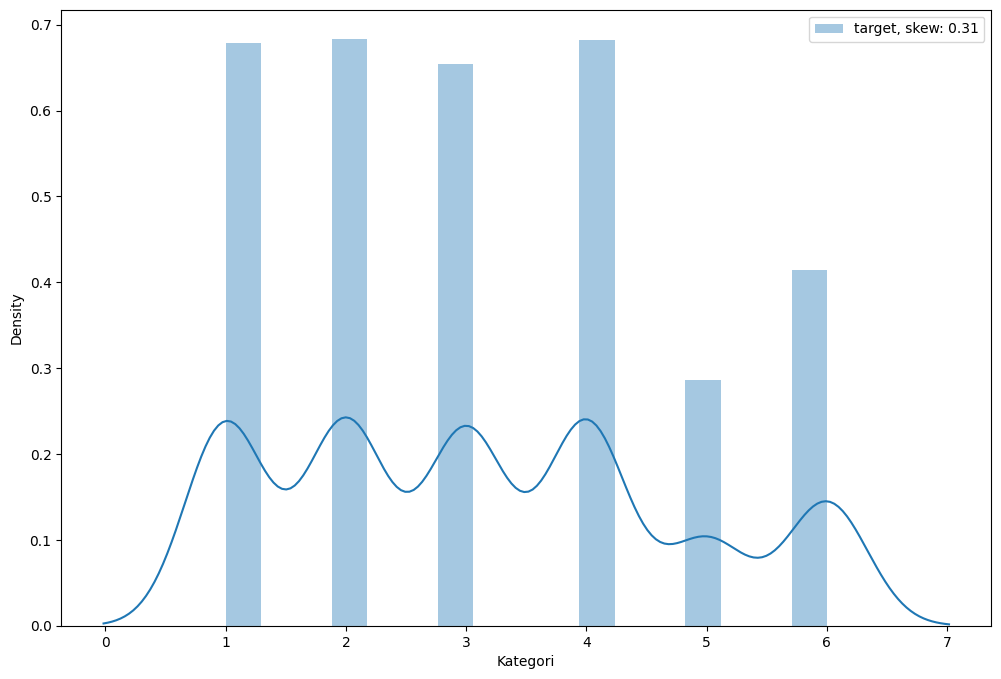

In [ ]:
# Visualizing the target variable
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

In [ ]:
dataset_label.value_counts()

2    501
4    500
1    498
3    480
6    304
5    210
Name: Kategori, dtype: int64

# Ekstraksi Fitur dan Machine Learning

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [ ]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

## load TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

## Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    #('vect', CountVectorizer()),
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [ ]:
parameters_nb = {
               'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
               #'tfidf__use_idf': (True, False),
               'model__alpha': (0, 1, 1e-2, 1e-3)
}

In [ ]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [ ]:
classifier_nb.fit(train_x, train_label.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0, 1, 0.01, 0.001),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [ ]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

In [ ]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  1.0
Recall Test set:  0.9037433155080213


In [ ]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  1.0
Precision Test set:  0.9043136987495856


In [ ]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  1.0
F1 Test set:  0.9031050319186746


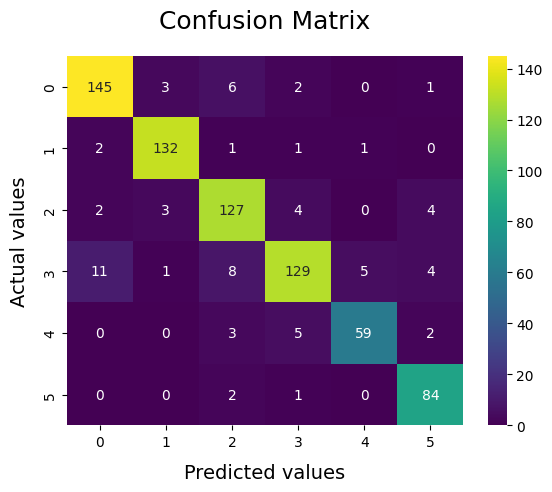

In [ ]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [ ]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 4))),
                ('model', MultinomialNB(alpha=0.001))])

In [ ]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 0.001
tfidf__ngram_range: (1, 4)


# Visualisasi

In [ ]:
models = [
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
         ]

In [ ]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,1.0,0.903743


In [ ]:
  models_comparison = [
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test)
                    ]

In [ ]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.903743,0.903743,0.904314,0.903105


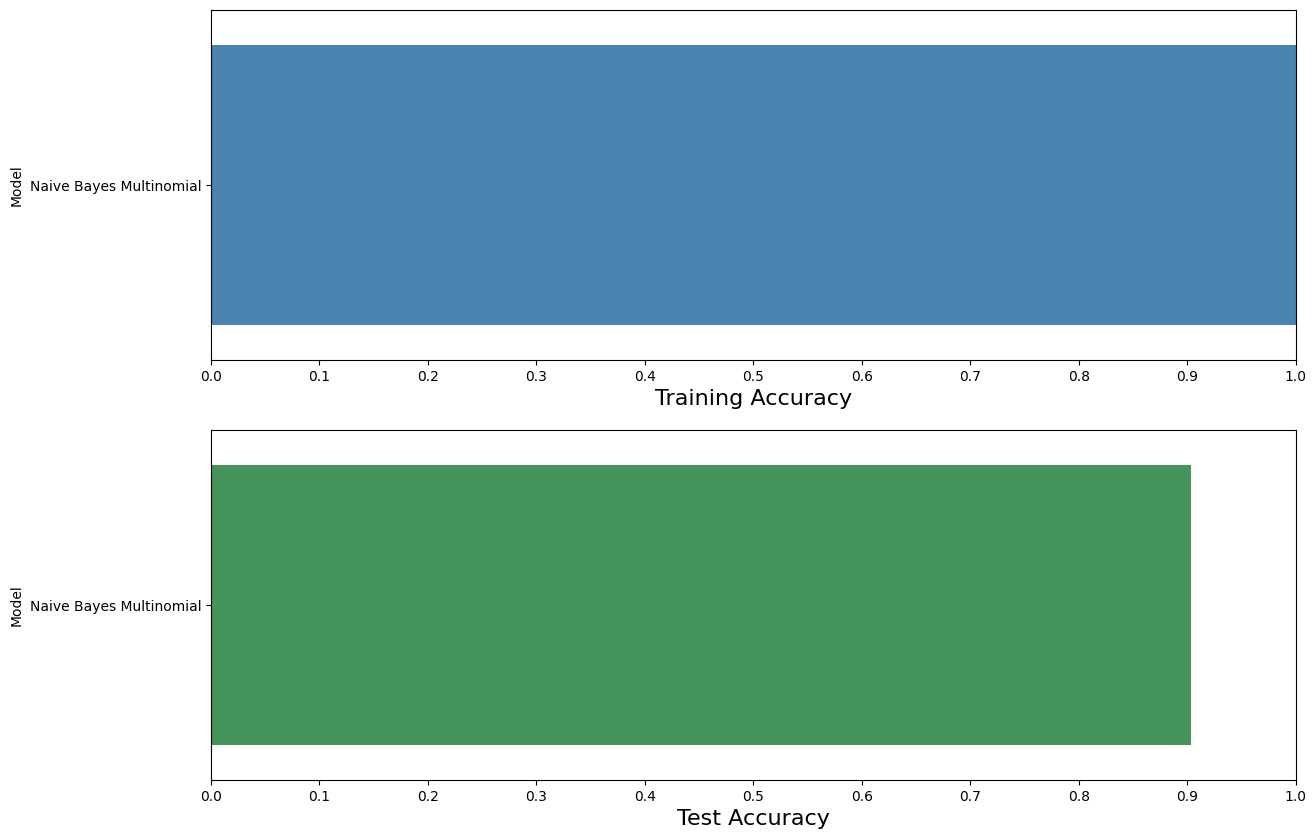

In [ ]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

# simpan kedalam joblib

In [ ]:
import joblib

In [ ]:
# save the model to disk
joblib.dump(classifier_nb.best_estimator_, '/content/drive/My Drive/Coba Code/main/Code Jadi/classifier_nb.best_estimator_baru.sav', compress=1)

['/content/drive/My Drive/Coba Code/main/Code Jadi/classifier_nb.best_estimator_baru.sav']